In [2]:
import os
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
%load_ext tensorboard

In [103]:
def get_tokens(): # function to get all tokens from the dataset and put them in a numpy array
    data = np.array(()) # data aggregator for one piece
    piece_counter = 0 # counter for the number of pieces
    for filename in os.listdir('Dataset_tokenized_BPE'): # iterate through all files in the folder
        if filename.endswith('.npy'): # if the file is a .npy file
            for i in range(len(np.load(('Dataset_tokenized_BPE/' + filename), allow_pickle=True)[()].get('tokens'))): # iterate through all the tokens in the file
                data = np.append(data, 89) # append the start token
                data = np.append(data, np.load(('Dataset_tokenized_BPE/' + filename), allow_pickle=True)[()].get('tokens')[i]) # append the tokens of one piece to the numpy array
                data = np.append(data, 176) # append the end token
                piece_counter += 1 # increase the piece counter
            continue 
        else: 
            continue 
    return data, piece_counter

In [110]:
tokens, piece_counter = get_tokens() # get all tokens from the dataset
print("smallest token:{}, biggest token:{}, number of unique tokens:{}, missing tokens:{}".format(np.min(tokens),np.max(tokens),np.unique(tokens).shape,set(range(0, 500))-set(tokens))) # print some information about the tokens
print("number of tokens: {}".format(len(tokens))) # print the number of tokens
print("number of pieces: {}".format(piece_counter)) # print the number of pieces
print("average tokens per piece: {}".format(len(tokens)/piece_counter)) # print average tokens per piece
unique_tokens, count = np.unique(tokens, return_counts=True)
print(dict(zip(unique_tokens, count))) # print the number of occurences of each token
vocab_size = int(np.max(tokens)) + 1 # get the size of the vocabulary
# unique, counts = np.unique(tokens, return_counts=True)
# print(dict(zip(unique, counts))) # print the number of occurences of each token
data = tf.cast(tokens, tf.int32) # put tokens into a tensor and cast to int32
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n] # first 90% of data
val_data = data[n:] # last 10% of data

def split_input_target(chunk): # split the input and the target
    input_text = chunk[:-1] # input is the sequence without the last token
    target_text = chunk[1:] # target is the sequence without the first token
    return input_text, target_text

def make_batches(ds):
    return ds.shuffle(4096).batch(batch_size).prefetch(tf.data.AUTOTUNE)

smallest token:1.0, biggest token:499.0, number of unique tokens:(495,), missing tokens:{0, 178, 180, 182, 186}
number of tokens: 1821144
number of pieces: 622
average tokens per piece: 2927.8842443729905
{1.0: 3257, 2.0: 3, 3.0: 17, 4.0: 4, 5.0: 65, 6.0: 117, 7.0: 150, 8.0: 273, 9.0: 310, 10.0: 1049, 11.0: 729, 12.0: 1551, 13.0: 1740, 14.0: 2061, 15.0: 2405, 16.0: 2107, 17.0: 3680, 18.0: 3281, 19.0: 3793, 20.0: 4097, 21.0: 4237, 22.0: 5641, 23.0: 3988, 24.0: 7081, 25.0: 7304, 26.0: 7682, 27.0: 8112, 28.0: 6580, 29.0: 11021, 30.0: 9102, 31.0: 12150, 32.0: 12375, 33.0: 12382, 34.0: 15197, 35.0: 11284, 36.0: 19087, 37.0: 15810, 38.0: 18261, 39.0: 18602, 40.0: 16561, 41.0: 20010, 42.0: 16571, 43.0: 22740, 44.0: 18633, 45.0: 20574, 46.0: 21075, 47.0: 16291, 48.0: 22034, 49.0: 17170, 50.0: 20122, 51.0: 17637, 52.0: 17425, 53.0: 21719, 54.0: 15413, 55.0: 20931, 56.0: 14869, 57.0: 16683, 58.0: 16490, 59.0: 11508, 60.0: 15490, 61.0: 10034, 62.0: 12191, 63.0: 9226, 64.0: 7897, 65.0: 8812, 66.0:

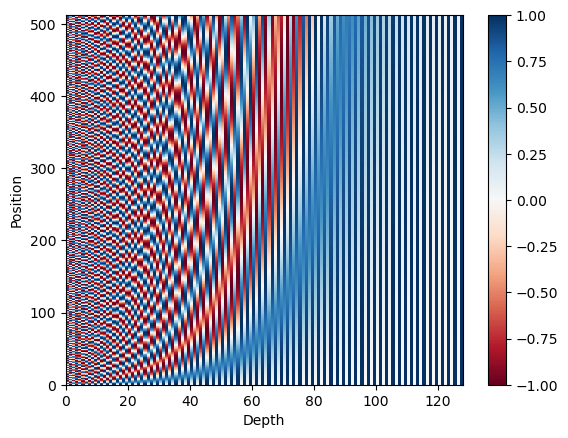

In [8]:
# postional encoding function
def positional_encoding(length, d_model):
    pos = np.arange(length)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    angle_rads = pos * angle_rates
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

pos_encoding = positional_encoding(seq_length, d_model)

# plot the positional encoding
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_model))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# layer for embedding and positional encoding
class PostionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model, block_size):
        super(PostionalEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.block_size = block_size
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, 
                          output_dim=d_model, # each token gets a 512-vector embedding
                          input_length=block_size)
        self.pos_encoding = positional_encoding(block_size, d_model)
        
    def call(self, x):
        return self.embedding(x) + self.pos_encoding[:, :self.block_size, :]

In [9]:
# dot-product attention
class ScaledDotProductAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads):
        super(ScaledDotProductAttention, self).__init__()
        self.head_size = d_model // n_heads
        self.key = tf.keras.layers.Dense(units=self.head_size, use_bias=False)
        self.query = tf.keras.layers.Dense(units=self.head_size, use_bias=False)
        self.value = tf.keras.layers.Dense(units=self.head_size, use_bias=False)

    @tf.function
    def call(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        # compute scores
        scores = tf.matmul(q,tf.transpose(k, perm=[0, 2, 1])) / tf.math.sqrt(tf.cast(self.head_size, tf.float32))
        tril = tf.linalg.band_part(tf.ones((T, T)), -1, 0)
        scores = tf.where(tril == 0, tf.fill(tril.shape, -float('inf')), scores)
        scores = tf.nn.softmax(scores, axis=-1)
        # weighted sum of values
        v = self.value(x)
        return tf.matmul(scores, v)

# multi-head attention
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.heads = [ScaledDotProductAttention(d_model, n_heads) for _ in range(n_heads)]
        self.dense = tf.keras.layers.Dense(units=d_model)
    
    @tf.function
    def call(self, x):
        x = tf.concat([head(x) for head in self.heads], axis=-1)
        return self.dense(x)
    
# feed-forward network
class FeedForwardNetwork(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate):
        super(FeedForwardNetwork, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=dff, activation=tf.nn.gelu)
        self.dense2 = tf.keras.layers.Dense(units=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    @tf.function
    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dropout(x)
        return x

# decoder layer
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, dff, dropout_rate):
        super(DecoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, n_heads)
        self.ffn = FeedForwardNetwork(d_model, dff, dropout_rate)
        self.layernorm1 = tf.keras.layers.LayerNormalization()
        self.layernorm2 = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()
    
    @tf.function
    def call(self, x):
        res_x = x
        x = self.layernorm1(x)
        x = self.mha(x)
        x = self.add([res_x, x])
        res_x = x
        x = self.layernorm2(x)
        x = self.ffn(x)
        x = self.add([res_x, x])
        return x
    
# decoder
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model, n_heads, dff, dropout_rate, n_layers, block_size):
        super(Decoder, self).__init__()
        self.embedding = PostionalEmbedding(vocab_size, d_model, block_size)
        self.layers = [DecoderLayer(d_model, n_heads, dff, dropout_rate) for _ in range(n_layers)]

    
    @tf.function
    def call(self, x):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x)
        return x
    
# transformer
class Transformer(tf.keras.Model):
    def __init__(self, vocab_size, d_model, n_heads, dff, dropout_rate, n_layers, block_size):
        super(Transformer, self).__init__()
        self.decoder = Decoder(vocab_size, d_model, n_heads, dff, dropout_rate, n_layers, block_size)
        self.final_dense = tf.keras.layers.Dense(units=vocab_size)
    
    @tf.function
    def call(self, x):
        x = self.decoder(x)
        logits = self.final_dense(x)
            
        try:      
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        return logits
    
    # function for generating tokens from the model 
    def generate(self, x, max_len):
        for i in range(max_len):
            logits = self(x)
            x = tf.concat([x, tf.expand_dims(tf.argmax(logits[:, -1, :], axis=-1), axis=-1)], axis=-1)
        return x

In [10]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
  
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)


In [7]:
d_model = 128 # also embedding size
dff = 512 # inner feedforward layer dim
n_heads = 8 # number of heads in the multihead attention layer
d_v, d_q, d_k = d_model // n_heads , d_model // n_heads , d_model // n_heads # dimension of the query, key and value vectors 
n_layers = 6 # number of layers
dropout_rate = 0.1 # dropout rate
epochs = 100
seq_length = 512 # length of the sequence
batch_size = 64 # batch size

In [11]:
# create tf.data.Dataset objects for training and validation
train_ds, val_ds = tf.data.Dataset.from_tensor_slices(train_data), tf.data.Dataset.from_tensor_slices(val_data)
# generate sequences of length with .batch and then split the sequences into input and target
train_ds, val_ds = train_ds.batch(seq_length+1, drop_remainder=True).map(split_input_target), val_ds.batch(seq_length+1, drop_remainder=True).map(split_input_target) 
# shuffle, batch and prefetch as usual
train_ds, val_ds = make_batches(train_ds), make_batches(val_ds)

# set the learning rate to our creeted custom schedule
learning_rate = CustomSchedule(d_model)

# create the optimizer with the learning rate and the other parameters as specified in the paper
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

# create the model with the specified parameters 
model = Transformer(vocab_size, d_model, n_heads, dff, dropout_rate, n_layers, seq_length)

model.build(input_shape=(None, seq_length))

model.load_weights('dmodel 128 dff 512 nheads 8 nlayers 6 dropout 0.1 epochs 100 seqlen 512 batch 64.h5')

# save weights of the model after every epoch
checkpoint_path = "checkpoints/train"
ckpt = tf.train.Checkpoint(transformer=model,
                            optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=None)

# compile the model with the masked loss and masked accuracy
model.compile(optimizer=optimizer, loss=masked_loss, metrics=[masked_accuracy])

# train the model 
model.fit(train_ds, epochs=epochs, validation_data=val_ds)

# save the model
model.save_weights('dmodel:{} dff:{} nheads:{} nlayers:{} dropout:{} epochs:{} seqlen:{} batch:{}.h5'.format(d_model, dff, n_heads, n_layers, dropout_rate, epochs, seq_length, batch_size))


In [204]:
max_len = 511
start_token = tf.constant([[89] + [0] * (seq_length - 1)], dtype=tf.int64)

def generate_tokens_greedy(model, start_token, max_len):
    for i in range(max_len):
        logits = model(start_token) # generate logits for the next token
        probs = tf.nn.softmax(logits, axis = -1) # get the probabilities 
        argmax = tf.argmax(probs, axis = -1) # get the token with the highest probability
        start_token_numpy = start_token.numpy() # convert the tensor to numpy array
        start_token_numpy[:, i+1] = argmax[:,i].numpy() # add the predicted token to the sequence
        start_token = tf.constant(start_token_numpy, dtype=tf.int64) # convert the numpy array to tensor
        if argmax[:,i].numpy() == 176: # stop when the end token is predicted
            break
    return start_token

def generate_tokens_sampling(model, start_token, max_len):
    for i in range(max_len):
        logits = model(start_token) # generate logits for the next token
        start_token_numpy = start_token.numpy() # convert the tensor to numpy array
        start_token_numpy[:, i+1] = tf.random.categorical(logits[:,i], num_samples=1).numpy() # sample a token from the logits and add it to the sequence
        start_token = tf.constant(start_token_numpy, dtype=tf.int64) # convert the numpy array to tensor
        if start_token_numpy[:, i+1] == 176: # stop when the end token is predicted
            break
    return start_token

generate_tokens_sampling(model, start_token, max_len)

<tf.Tensor: shape=(1, 512), dtype=int64, numpy=
array([[ 89, 200,  49, 315,  43, 222, 204,  46, 381,  40, 222, 212,  43,
        349,  33, 496,  35, 223, 298,  37, 397,  39, 258, 192,  43, 231,
        194,  43, 231, 196,  46, 231, 198, 445, 200,  46, 315,  38, 231,
        204,  40, 231, 206,  36, 231, 208,  40, 231, 210,  38, 227, 212,
         40, 231, 214,  36, 227, 216,  37, 325,  37, 258, 188,  40, 231,
        190,  36, 231, 192,  40, 231, 194,  37, 258, 196,  40, 231, 198,
         36, 231, 200,  40, 497,  36, 231, 204,  40, 231, 206,  34, 231,
        208,  40, 231, 210,  37, 258, 212,  40, 231, 214,  37, 231, 216,
         40, 231, 218,  37, 258, 188,  40, 231, 190,  36, 258, 192,  40,
        231, 194,  37, 231, 196,  40, 231, 198,  36, 258, 200,  40, 497,
         34, 231, 204,  40, 231, 206,  34, 231, 208,  40, 231, 210,  34,
        232, 212,  42, 330,  35, 423,  38, 426,  39, 302,  35, 219, 188,
         40, 376,  38, 450,  42, 309,  40, 220, 196,  42, 360,  40, 475,
   